In [45]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from pykalman import KalmanFilter
np.random.seed(107)

import sys
sys.path.append('/Users/amandeep/dev/cs230/Auquan/auquantoolbox')
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

# DOWNLOAD DATA FROM YAHOO

In [46]:
startDateStr = '2008/10/01'
endDateStr = '2018/10/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = list(set(['ITOT', 'ACWI', 'IWV', 'VT', 'VTI',
                 'DIA', 'RSP', 'IOO', 'IVV', 'SPY',
                 'SHE', 'IWM', 'OEF', 'QQQ',
                 'CVY', 'RPG', 'RPV', 'IWB', 'IWF', 
                 'IWD', 'IVW', 'IVE', 'PKW', 
                 'PRF', 'SDY', 'VV', 'VUG', 
                 'VTV', 'MGC', 'MGK', 'MGV', 'VIG', 
                 'VYM', 'DTN', 'DLN', 'MDY', 'DVY', 
                 'IWR', 'IWP', 'IWS', 'IJH', 'IJK', 
                 'IJJ', 'PDP', 'DON', 'IWC', 'IWM', 
                 'IWO', 'IWN', 'IJR', 'IJT', 'IJS', 
                 'EEB', 'IDV', 'ACWX', 'BKF', 'EFA', 
                 'EFG', 'EFV', 'SCZ', 'EEM', 'PID', 
                 'DWX', 'DEM', 'DGS', 'AAXJ', 'EZU', 
                 'EPP', 'IEV', 'ILF', 'FEZ', 'VGK', 
                 'VPL', 'DFE', 'EWA', 'EWC', 'EWG', 
                 'EWI', 'EWJ', 'EWD', 'EWL', 'EWP', 
                 'EWU', 'DXJ', 'EWZ', 'FXI', 'EWH', 
                 'EWW', 'RSX', 'EWS', 'EWM','EWY', 
                 'EWT', 'EPI', 'XLY', 'IYC', 'ITB', 
                 'XHB', 'VCR','XLP', 'IYK', 'VDC', 
                 'XLE', 'IYE', 'IGE', 'OIH', 'XOP', 
                 'VDE', 'QCLN', 'XLF','IYF', 'KBE', 
                 'KRE', 'VFH']))
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['close']

Processing data for stock: VFH
Processing data for stock: EPP
Processing data for stock: IWF
Processing data for stock: AAXJ
Processing data for stock: EPI
Processing data for stock: VYM
Processing data for stock: SPY
Processing data for stock: IWD
Processing data for stock: IWC
Processing data for stock: IWB
Processing data for stock: IWO
Processing data for stock: IWN
Processing data for stock: IWM
Processing data for stock: PID
Processing data for stock: IOO
Processing data for stock: IWV
Processing data for stock: IWS
Processing data for stock: IWR
Processing data for stock: IWP
Processing data for stock: VIG
Processing data for stock: OIH
Processing data for stock: QQQ
Processing data for stock: DTN
Processing data for stock: XLF
Processing data for stock: XLE
Processing data for stock: EEM
Processing data for stock: VDC
Processing data for stock: VDE
Processing data for stock: DEM
Processing data for stock: XLY
Processing data for stock: EEB
Processing data for stock: PKW
Process

# DATA ANALYTICS

In [47]:
print(data.shape)
data.iloc[:3,:10]

(2518, 113)


,VFH,EPP,IWF,AAXJ,EPI,VYM,SPY,IWD,IWC,IWB
2008-10-01,40.090000,35.860001,47.509998,42.340000,15.97,42.279999,116.059998,63.919998,43.880001,63.099998
2008-10-02,38.650002,33.700001,45.470001,40.700001,15.30,41.169998,111.849998,62.020000,42.090000,60.459999
2008-10-03,37.130001,33.299999,44.840000,40.169998,14.85,40.490002,110.339996,60.860001,41.020000,59.680000


In [48]:
# Checking for any null values in data
d = data.isnull().any()
print(d[d == True])

Series([], dtype: bool)


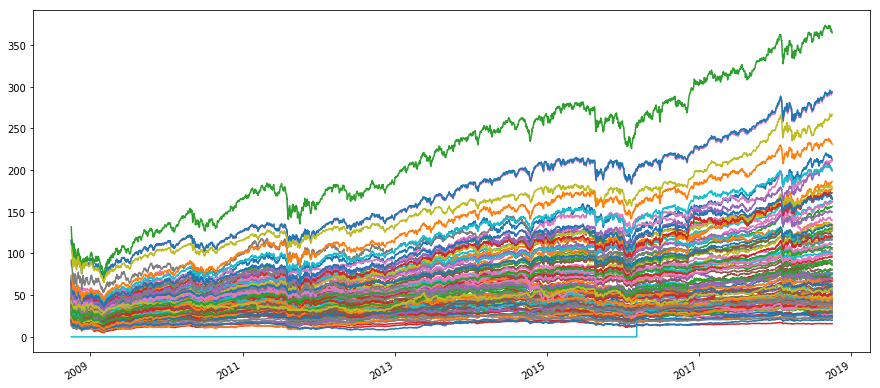

In [49]:
# Create a plot of the time series to visualize the data
for i in range(data.shape[1]):
    S = data.iloc[:, i]
    S.plot(figsize=(15,7))

# Generate Co-Integrated Pairs

In [51]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = {}
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs[(keys[i], keys[j])] = result
    return score_matrix, pvalue_matrix, pairs

scores, pvalues, pairs = find_cointegrated_pairs(data)

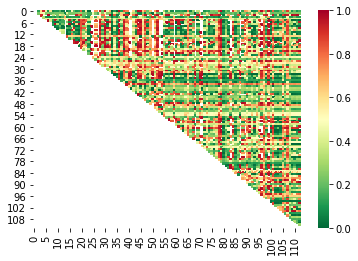

In [55]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
#m = [0,0.2,0.4,0.6,0.8,1]
sns.heatmap(pvalues,  cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
pyplot.show()

In [56]:
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data[:10]

[(('SPY', 'IVV'), 0.0),
 (('IWV', 'VTI'), 1.6627551017454548e-21),
 (('IVE', 'IJJ'), 1.7380121213434282e-05),
 (('PRF', 'IVE'), 5.63604448556219e-05),
 (('VYM', 'DVY'), 6.758674613499686e-05),
 (('VFH', 'KBE'), 9.760150863380905e-05),
 (('VT', 'ACWI'), 0.00014183677751106706),
 (('DON', 'DVY'), 0.00015773162904002519),
 (('ITOT', 'VV'), 0.00016849004545661979),
 (('EWT', 'VPL'), 0.0002570590858793808)]

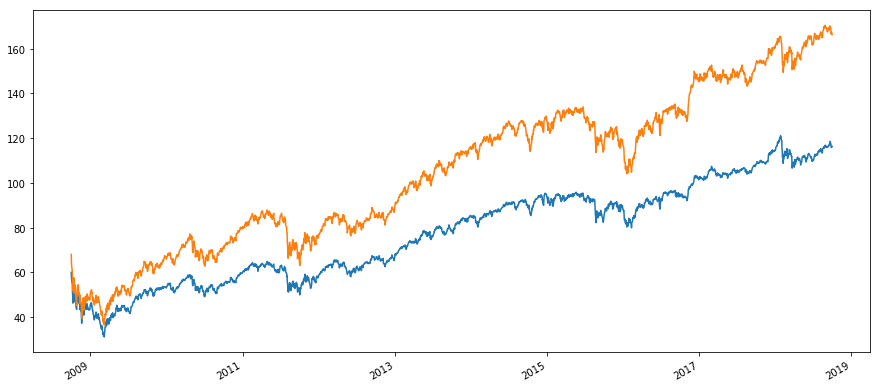

In [57]:
best_pair_data = pd.DataFrame({'S1':data['IVE'],'S2':data['IJJ']})
best_pair_data['S1'].plot(figsize=(15,7))
best_pair_data['S2'].plot(figsize=(15,7))

## Spreads for Ground Truth

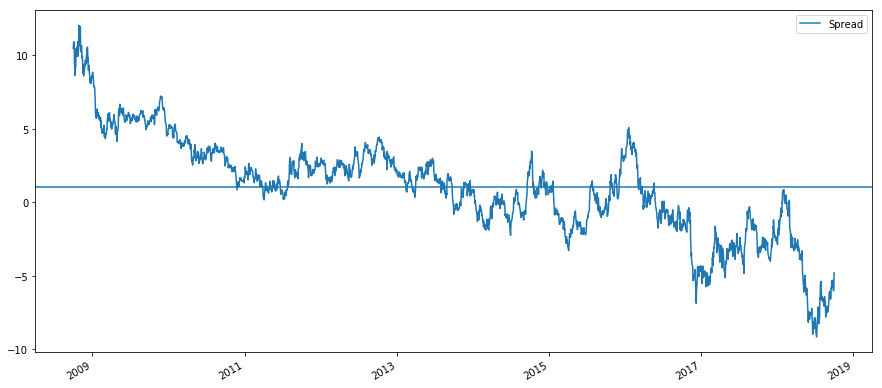

In [58]:
est = sm.OLS(best_pair_data.S1, best_pair_data.S2)
est = est.fit()
alpha = -est.params[0]
best_pair_data['Spread'] = best_pair_data.S1 + (best_pair_data.S2 * alpha)
best_pair_data['Spread'].plot(figsize=(15,7))
pyplot.axhline(best_pair_data['Spread'].mean())
pyplot.legend(['Spread'])

## Spread Prediction using Kalman Filter

In [59]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
 
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
 
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
 
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
 
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [60]:
def normalize(series):
    return (series - series.mean()) / np.std(series)

In [61]:
state_means = - KalmanFilterRegression(KalmanFilterAverage(best_pair_data.S1),KalmanFilterAverage(best_pair_data.S2))[:,0]
best_pair_data['Kalman_Predicted_Spread'] = normalize(best_pair_data.S1 + (best_pair_data.S2 * state_means))

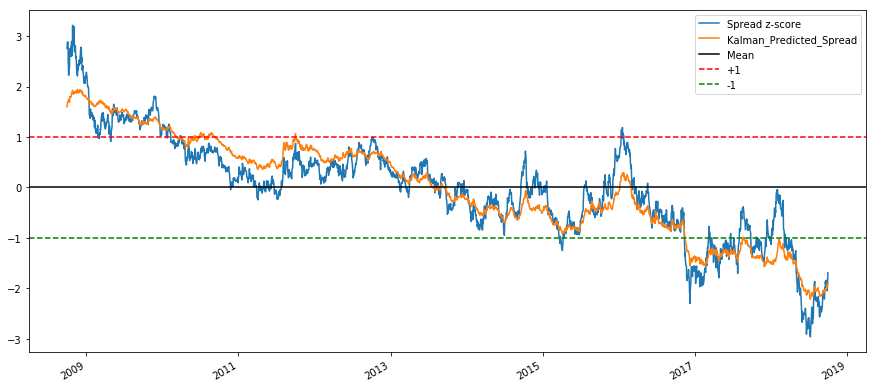

In [62]:
normalize(best_pair_data['Spread']).plot(figsize=(15,7))
best_pair_data['Kalman_Predicted_Spread'].plot(figsize=(15,7))
pyplot.axhline(normalize(best_pair_data['Spread']).mean(), color='black')
pyplot.axhline(1.0, color='red', linestyle='--')
pyplot.axhline(-1.0, color='green', linestyle='--')
pyplot.legend(['Spread z-score', 'Kalman_Predicted_Spread', 'Mean', '+1', '-1'])
pyplot.show()

## Spread Prediction using LSTM

In [63]:
#Use MinMaxScaler to normalize Weighted Price to range from 0 to 1
values = best_pair_data['Spread'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [64]:
# Split 90% of data for training and 10% for testing
train_size = int(len(scaled) * 0.9)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

(2266, 252)


In [65]:
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

# Generate dataset for trainX, trainY, testX, testY
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

2265
251


In [66]:
# Reshape X for model training
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Running the LSTM model with 300 epochs
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


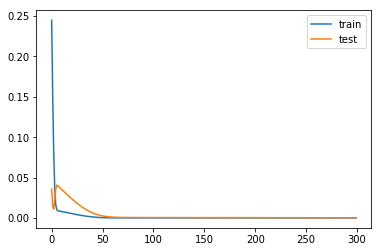

In [68]:
# Plot line graph to show amount loss according the the epoch
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

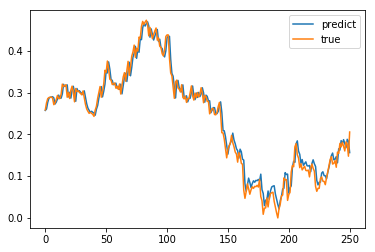

In [69]:
# Make prediction using textX and plotting line graph against testY
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [71]:
# Scaler Inverse Y back to normal value
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [72]:
predictDates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))
#Plot predicted and actual line graph
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

In [73]:
# Test Data
test_data = pd.DataFrame({'S1':best_pair_data['S1'].iloc[-len(testX):],'S2':best_pair_data['S2'].iloc[-len(testX):]})
test_data['Actual_Spread'] = best_pair_data['Spread'].iloc[-len(testX):]
test_data['Kalman_Predicted_Spread']  = best_pair_data['Kalman_Predicted_Spread'].iloc[-len(testX):]
test_data['LSTM_Predicted_Spread'] = yhat_inverse
# RMSE
rmse_kalman = sqrt(mean_squared_error(test_data['Actual_Spread'], test_data['Kalman_Predicted_Spread']))
print('Kalman Test RMSE: %.3f' % rmse_kalman)
rmse_LSTM = sqrt(mean_squared_error(test_data['Actual_Spread'], test_data['LSTM_Predicted_Spread']))
print('LSTM Test RMSE: %.3f' % rmse_LSTM)

Kalman Test RMSE: 3.435
LSTM Test RMSE: 0.412


## Trading Strategy

In [74]:
# Choose Spreads to trade on
trade_using = "Actual_Spread"
data = test_data[trade_using]

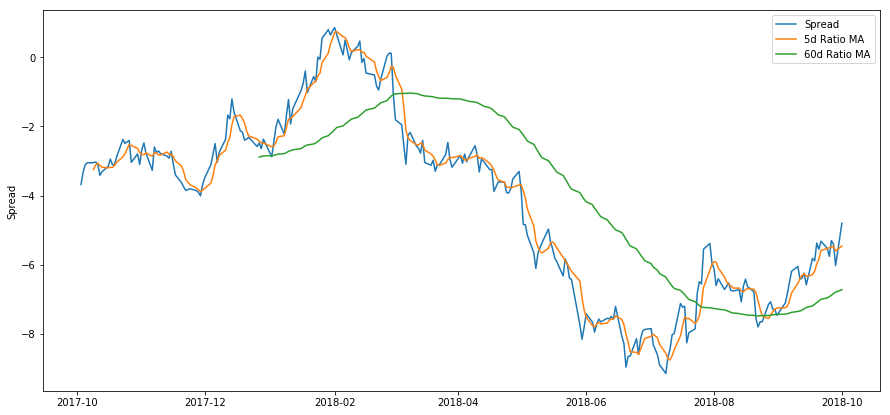

In [75]:
ratios_mavg5 = data.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = data.rolling(window=60,
                               center=False).mean()

std_60 = data.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
pyplot.figure(figsize=(15,7))
pyplot.plot(data.index, data.values)
pyplot.plot(ratios_mavg5.index, ratios_mavg5.values)
pyplot.plot(ratios_mavg60.index, ratios_mavg60.values)

pyplot.legend(['Spread','5d Ratio MA', '60d Ratio MA'])

pyplot.ylabel('Spread')
pyplot.show()

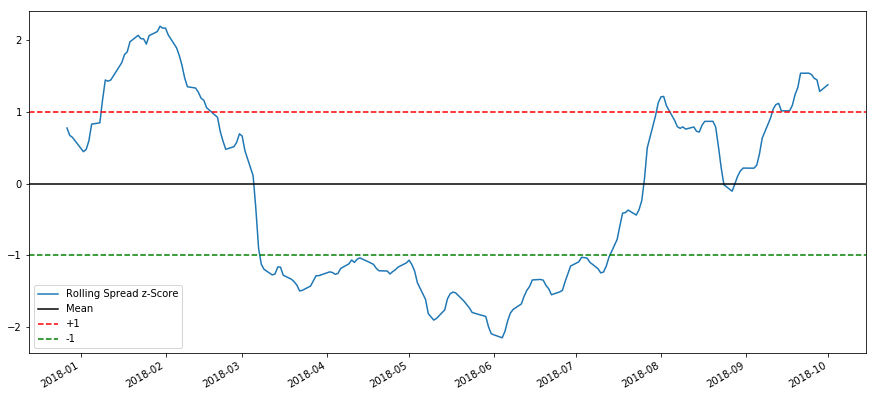

In [76]:
# Take a rolling 60 day standard deviation
std_60 = data.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

pyplot.figure(figsize=(15,7))
zscore_60_5.plot()
pyplot.axhline(0, color='black')
pyplot.axhline(1.0, color='red', linestyle='--')
pyplot.axhline(-1.0, color='green', linestyle='--')
pyplot.legend(['Rolling Spread z-Score', 'Mean', '+1', '-1'])
pyplot.show()

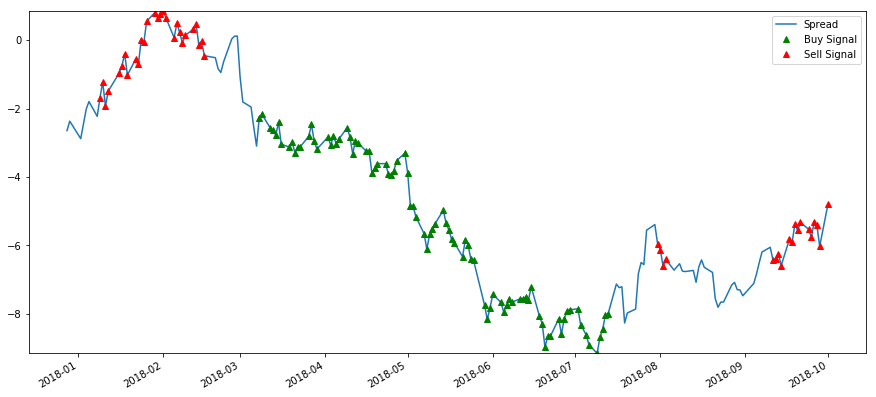

In [77]:
# Plot the ratios and buy and sell signals from z score
pyplot.figure(figsize=(15,7))

data[60:].plot()
buy = data.copy()
sell = data.copy()
buy[zscore_60_5>-1] = -100
sell[zscore_60_5<1] = -100
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = pyplot.axis()
pyplot.axis((x1,x2,data.min(),data.max()))
pyplot.legend(['Spread', 'Buy Signal', 'Sell Signal'])
pyplot.show()

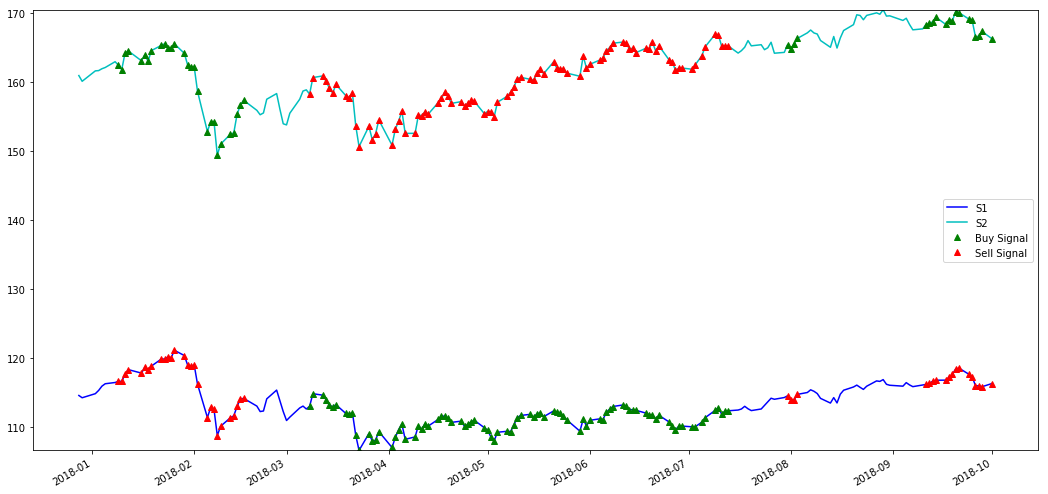

In [78]:
# Plot the prices and buy and sell signals from z score
pyplot.figure(figsize=(18,9))
S1 = test_data.S1
S2 = test_data.S2

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=-100] = S1[buy!=-100]
sellR[buy!=-100] = S2[buy!=-100]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=-100] = S2[sell!=-100]
sellR[sell!=-100] = S1[sell!=-100]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = pyplot.axis()
pyplot.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

pyplot.legend(['S1', 'S2', 'Buy Signal', 'Sell Signal'])
pyplot.show()

In [79]:
# Trade using a simple strategy
def trade(S1, S2, spread, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = spread.rolling(window=window1, center=False).mean()
    ma2 = spread.rolling(window=window2, center=False).mean()
    std = spread.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * spread[i]
            countS1 -= 1
            countS2 += spread[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * spread[i]
            countS1 += 1
            countS2 -= spread[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i] - S2[i] * countS2
            countS1 = 0
            countS2 = 0
    return money

In [80]:
profit = trade(test_data['S1'], test_data['S2'], data, 60, 5)
profit

106602.63319619416

In [ ]:
# Actual Spread
# 106602.63319619416
# Kalman Filter
# 24371.12273878289
# LSTM
# 105378.50889703228